# Forecasting PEPCO Region's Load (i.e Instantaneous Electricty Usage)
While not the core consideration of this endeavor, this data has lower variance and is better suited to be accurately predicted using the Prophet library, so modeling was performed for fun to see how well it could be forecasted.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from datetime import date, datetime
import holidays

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

%load_ext autoreload
import helper_functions as hlp

# Importing Data
Importing previously prepared data.  
Converting time columns to proper datetime format.  
Creating a separate DataFrame with only the data from 2016 onward for use in modeling.

In [2]:
# importing data and converting datetimes
mw_data = pd.read_csv('data/processed/mw_data.csv')
mw_data['datetime_beginning_utc'] = pd.to_datetime(mw_data['datetime_beginning_utc'])
mw_data['datetime_beginning_ept'] = pd.to_datetime(mw_data['datetime_beginning_ept'])

# subsetting data to be from 2016 onwards
mw_data = mw_data.loc[mw_data['datetime_beginning_ept']
                      >= pd.Timestamp(2016, 1, 1)]

In [3]:
mw_data.describe()

,pepco_mw,total_outages_mw,planned_outages_mw,maintenance_outages_mw,forced_outages_mw,enthalpy,apparentTemperature,dewPoint,humidity,humidity_ratio,DD,CDD,HDD,uvIndex,peak_hour
count,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000,34080.000000
mean,3036.968713,15241.348797,8443.485094,4856.125763,1941.737940,23.276091,59.087889,47.073609,0.672790,0.008354,0.706830,0.230248,0.476582,1.298166,0.468545
std,658.241332,9619.669136,9009.800508,2150.121215,1032.653181,9.675226,19.911984,19.206677,0.189049,0.005128,0.499428,0.357012,0.584330,2.120019,0.499017
min,1812.757000,1444.000000,0.000000,-371.000000,265.000000,2.044572,-0.790000,-14.280000,0.130000,0.000355,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2579.313500,6869.000000,194.000000,3294.000000,1221.000000,14.724860,43.220000,31.710000,0.520000,0.003701,0.310000,0.000000,0.000000,0.000000,0.000000
50%,2923.118000,12397.000000,4743.000000,4773.000000,1715.000000,23.035955,60.890000,49.980000,0.690000,0.007594,0.590000,0.000000,0.170000,0.000000,0.000000
75%,3397.080750,24198.000000,16484.750000,6225.000000,2494.000000,31.802373,74.470000,64.150000,0.850000,0.012789,1.040000,0.390000,0.910000,2.000000,1.000000
max,5813.240000,36309.000000,28775.000000,13155.000000,8538.000000,46.034146,113.700000,78.040000,1.000000,0.020865,2.740000,2.030000,2.740000,11.000000,1.000000


Since historical Pepco forecasts aren't available, I will compare PJM's Forecasted and Actual Mid-Atlantic Region Load to provide a proxy for the relative performance of my model versus the professional model. The Mid-Atlantic Region includes PEPCO and their loads have a correlation coefficient of 0.97.

In [4]:
# importing the Mid-Atlantic load and forecast data and converting datetimes
frcst_data = pd.read_csv('data/processed/data_clean.csv')
frcst_data = frcst_data.loc[:, ['datetime_beginning_ept', 'midatl_mw',
                                'midatl_forecast_load_mw', 'midatl_forecast_load_mw_final']]
frcst_data['datetime_beginning_ept'] = pd.to_datetime(frcst_data['datetime_beginning_ept'])

# subsetting data to be from 2016 onwards
frcst_data = frcst_data.loc[frcst_data['datetime_beginning_ept']
                            >= pd.Timestamp(2016, 1, 1)]

# Baseline Model with No Exogenous Regressors

In [5]:
# initializing baseline model
m_mw = hlp.init_prophet_model()

# generating the properly formatted dataframe
df_mw = hlp.prophet_df(mw_data, 'datetime_beginning_ept', 'pepco_mw')

# generating the prediction dataframe
pred_mw = df_mw.drop(columns=['y']).copy()

In [6]:
# fitting the baseline model
m_mw.fit(df_mw);

In [7]:
# generating predictions
fcst_mw = m_mw.predict(pred_mw)

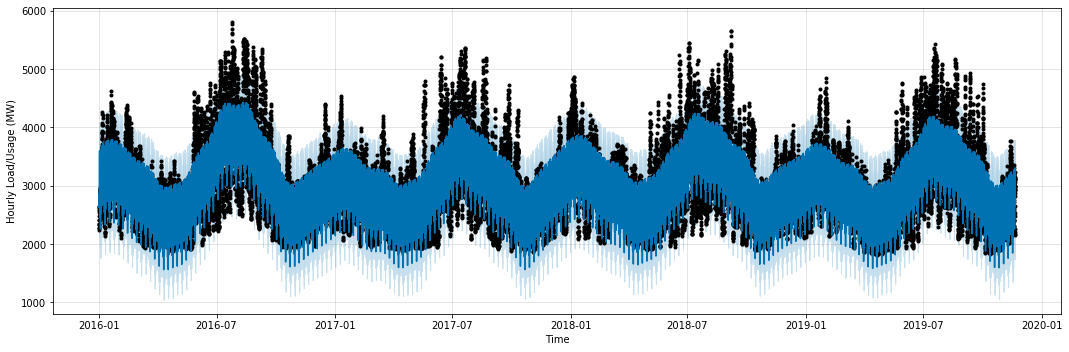

In [8]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_mw.plot(fcst_mw, xlabel='Time', ylabel='Hourly Load/Usage (MW)',
                uncertainty=True, ax=ax)

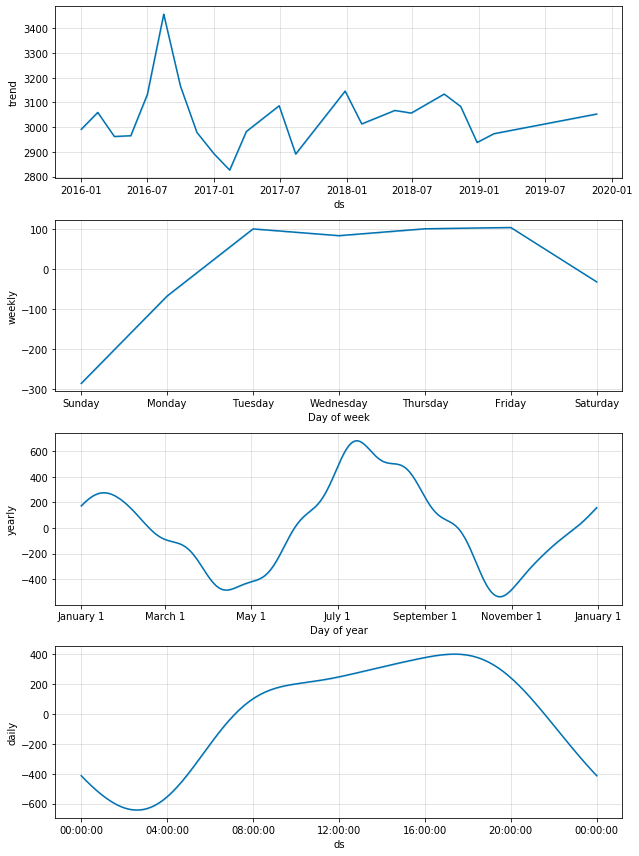

In [9]:
# plotting the decomposition
fig = m_mw.plot_components(fcst_mw)

In [10]:
# generating dataframe with predictions and actual values for comparison
compare_mw = fcst_mw.set_index('ds')[['yhat',
                                      'yhat_lower',
                                      'yhat_upper']
                                     ].join(df_mw.set_index('ds'))
# printing the results 
# Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percent Error (MAPE)
hlp.print_metrics(compare_mw['y'], compare_mw['yhat'])

MSE:  151188.38
MAE:  300.51
MAPE:  9.8 %


# Final Model with Regressors
Feature selection was performed by iterating through various combinations of features, and the complete set of features selected during EDA performed best, and ultimately two humidity features were added to the features originally selected during EDA, yielding some model improvement. Hyperparameter tuning was conducted, and a only a modification to the changepoint_prior scale yielded meaningful improvements over the default values. The process for feature selection and hyperparameter tuning was the same as that described in the Modeling RT Pricing notebook.
  
Power Transformation of the target did not yield improved results due to the more stable reality of the time series.  

In [11]:
# creating list of all regressors for use in the model
mw_final_reg = list(mw_data.iloc[:,3:].columns)

# initializing baseline model
m_mw_final = hlp.init_prophet_model(mw_final_reg,
                                    model=Prophet(changepoint_prior_scale = 0.4))

# generating the properly formatted dataframe
df_mw_final = hlp.prophet_df(mw_data, 'datetime_beginning_ept',
                            'pepco_mw', mw_final_reg)

# generating the prediction dataframe
pred_mw_final = df_mw_final.drop(columns=['y']).copy()

In [12]:
# fitting the model
m_mw_final.fit(df_mw_final);

In [13]:
# generating predictions
fcst_mw_final = m_mw_final.predict(pred_mw_final)

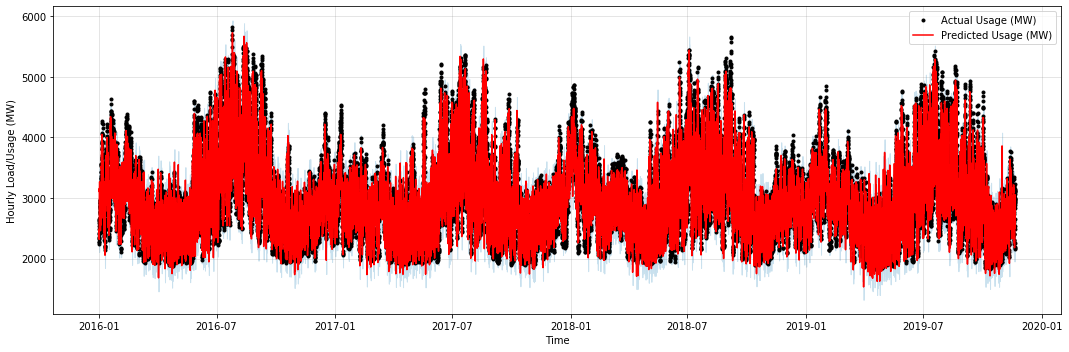

In [14]:
# plotting the actuals and predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_mw_final.plot(fcst_mw_final, xlabel='Time', ylabel='Hourly Load/Usage (MW)',
                     uncertainty=True, ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Usage (MW)")
plt.gca().get_lines()[1].set_label("Predicted Usage (MW)")
plt.legend();
plt.savefig('img/MW_Predictions.png');

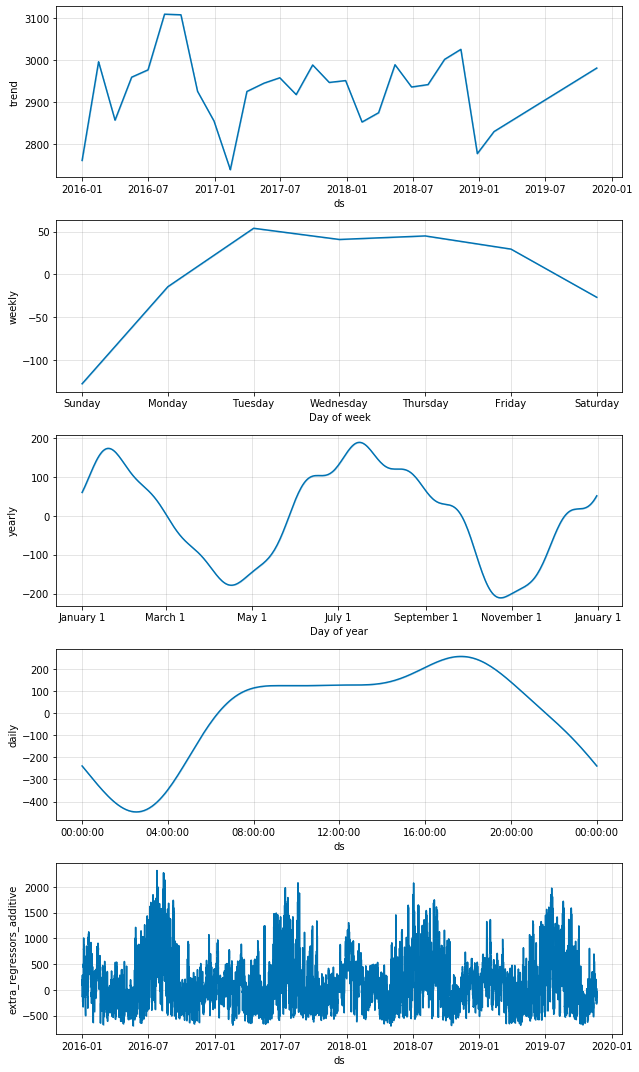

In [15]:
# plotting the decomposition
fig = m_mw_final.plot_components(fcst_mw_final)

In [16]:
# generating dataframe with predictions and actual values for comparison
compare_mw_final = fcst_mw_final.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']
                                                 ].join(df_mw_final.set_index('ds'))
# printing the model results
print("Final Model Performance:")
hlp.print_metrics(compare_mw_final['y'], compare_mw_final['yhat'])

Final Model Performance:
MSE:  27696.62
MAE:  130.27
MAPE:  4.42 %


Since historical Pepco forecasts aren't available, PJM's Forecasted and Actual Mid-Atlantic Region Load are compared to provide a proxy for the relative performance of my model versus the professional model. It is shown that the Mid-Atlantic Region and PEPCO, which is a subset of the Mid-Atlantic Region, have a correlation coefficient of 0.97. My model with 4.42% error is in line with PJMs with errors ranging from 1.56 - 2.9%.  
  
Forecasts are available at set 4 hour increments (e.g. 24 hours of forecasts published at 4:45 am every day), so the time between a given forecast and the actual value aren't the same for every hour depending on the set times of published forecasts. Generally the oldest available forecast is a day-and-a-half-ahead, and the latest is a-couple-hours-ahead.

In [17]:
# comparing to available historical forecasts for the Mid-Atlantic (MIDATL) region
print("MIDATL-PEPCO Correlation: ", round(np.corrcoef(frcst_data['midatl_mw'],
                                                      mw_data['pepco_mw'])[0][1],
                                          2))
print("\nDay-Ahead MIDATL Forecast Performance:")
hlp.print_metrics(frcst_data['midatl_mw'], frcst_data['midatl_forecast_load_mw'])
print("\nHours-Ahead MIDATL Forecast Performance:")
hlp.print_metrics(frcst_data['midatl_mw'], frcst_data['midatl_forecast_load_mw_final'])

MIDATL-PEPCO Correlation:  0.97

Day-Ahead MIDATL Forecast Performance:
MSE:  1503051.29
MAE:  909.19
MAPE:  2.9 %

Hours-Ahead MIDATL Forecast Performance:
MSE:  353984.4
MAE:  473.97
MAPE:  1.56 %


# Cross Validating the Final Prediction Model
The initial model is fit on the 2016 and 2017 data. All prediction horizons are the subsequent 168 hours (1 week), and then the model incorporates an additional 84 hours (half-week) into the time period that is fit followed by another 168 hour prediction horizon. This process repeats until the end of the time period for which there is data. A prediction horizon of 7 days was selected because that is how far out PJM publishes their load forecasts (although not all the historical forecasts are archived for publicly availability), and the period was selected to be half the horizon per the Prophet library's suggestion.

In [18]:
# performing the cross validation
mw_cv = cross_validation(m_mw_final, initial='26285 hours',
                         period='84 hours', horizon = '168 hours')

INFO:fbprophet:Making 91 forecasts with cutoffs between 2019-01-02 23:00:00 and 2019-11-13 23:00:00


In [40]:
# evaluating the tabular results 
# CV shows comparable results to the Final Model with a mean MAPE of 4.68% vs. Model's 4.42%
# and a standard deviation of 0.76%
mw_perf = performance_metrics(mw_cv, rolling_window=0)
print('Mean 7-Day Forecast MAPE: ',
      round(mw_perf['mape'].mean()*100,2),
      '%')
mw_perf

Mean 7-Day Forecast MAPE:  4.68 %


,horizon,mse,rmse,mae,mape,coverage
0,0 days 01:00:00,16627.409422,128.947313,100.034173,0.035675,0.857143
1,0 days 02:00:00,17143.874699,130.934620,103.543269,0.037876,0.901099
2,0 days 03:00:00,21942.528680,148.130107,117.520481,0.042430,0.846154
3,0 days 04:00:00,25186.035776,158.701089,125.502496,0.044960,0.846154
4,0 days 05:00:00,26961.858931,164.200667,129.755018,0.045628,0.857143
5,0 days 06:00:00,29073.169035,170.508560,135.957806,0.045441,0.802198
6,0 days 07:00:00,51226.845023,226.333482,181.689841,0.058098,0.670330
7,0 days 08:00:00,29811.818150,172.660992,136.291111,0.041919,0.780220
8,0 days 09:00:00,31762.991682,178.221749,143.809496,0.045180,0.769231
9,0 days 10:00:00,36994.748477,192.340189,152.415503,0.047785,0.725275


In [35]:
mw_perf.describe()

,horizon,mse,rmse,mae,mape,coverage
count,168,168.000000,168.000000,168.000000,168.000000,168.000000
mean,3 days 12:30:00,31379.215355,175.265953,138.884951,0.046780,0.786235
std,2 days 00:38:29.565701,9554.415121,25.787973,21.802441,0.007606,0.074492
min,0 days 01:00:00,16627.409422,128.947313,100.034173,0.032666,0.560440
25%,1 days 18:45:00,24280.081417,155.820568,121.391495,0.041465,0.736264
50%,3 days 12:30:00,29665.661784,172.237193,136.327146,0.045019,0.802198
75%,5 days 06:15:00,35727.997245,189.018288,150.747677,0.051235,0.846154
max,7 days 00:00:00,62424.727939,249.849411,199.829961,0.068695,0.901099


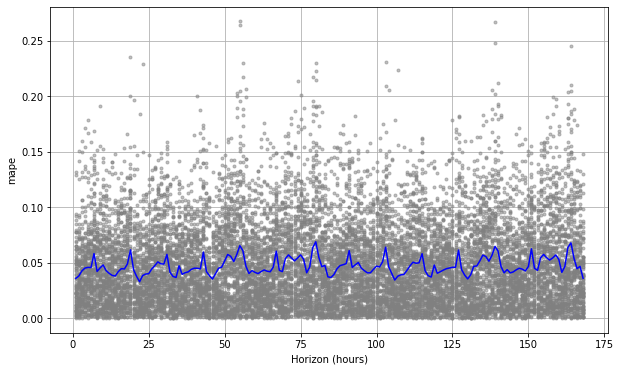

In [37]:
# plotting the results
fig = plot_cross_validation_metric(mw_cv, metric='mape', rolling_window=0)